# Fly species Identification using Wing Venation Patterns - A Deep Learning Approach

## Mount the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cp -r ./drive/MyDrive/Master/WingsFlyImage/Task1/fold1/ ./

In [ ]:

train_data_dir = './fold1/train'
test_data_dir = './fold1/test'

In [ ]:
import os

In [ ]:
sum = 0
for cls in os.listdir(train_data_dir):
    print(cls, ':', len(os.listdir(train_data_dir + '/' + cls)))
    sum += len(os.listdir(train_data_dir + '/' + cls))
sum

B.karnyi : 16
C.megacephala : 65
A.gressitti : 11
L.alba : 8
C.bezziana : 45
S.princeps : 9
S.nudiseta : 80
S.aquila : 15
C.albiceps : 80
C.nigripes : 8
L.sericata : 80
C.albiceps_mutant : 80
C.rufifacies : 30
C.vicina : 80


607

In [ ]:
sum = 0
for cls in os.listdir(test_data_dir):
    print(cls, ':', len(os.listdir(test_data_dir + '/' + cls)))
    sum += len(os.listdir(test_data_dir + '/' + cls))
sum

B.karnyi : 4
C.megacephala : 17
A.gressitti : 2
L.alba : 2
C.bezziana : 12
S.princeps : 2
S.nudiseta : 20
S.aquila : 4
C.albiceps : 20
C.nigripes : 2
L.sericata : 20
C.albiceps_mutant : 20
C.rufifacies : 7
C.vicina : 20


152

## Import the Dataset Into PyTorch

Use the `ImageFolder` class from `torchvision`.



In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torchvision.transforms as tt

train_dataset = ImageFolder(train_data_dir, tt.Compose([tt.Grayscale(),
                                                        tt.ToTensor()]))
test_dataset = ImageFolder(test_data_dir, tt.Compose([tt.Grayscale(),
                                                      tt.ToTensor()]))

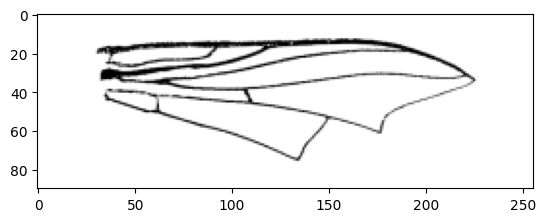

In [ ]:
# Example of a training data

img, label = train_dataset[8]
plt.imshow(img.permute((1, 2, 0)), cmap = 'gray')

In [ ]:
import torch
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
from sklearn.model_selection import train_test_split

train_ds, valid_ds = train_test_split(train_dataset, test_size = 0.2, random_state=42, stratify=train_dataset.targets)
test_ds = test_dataset

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

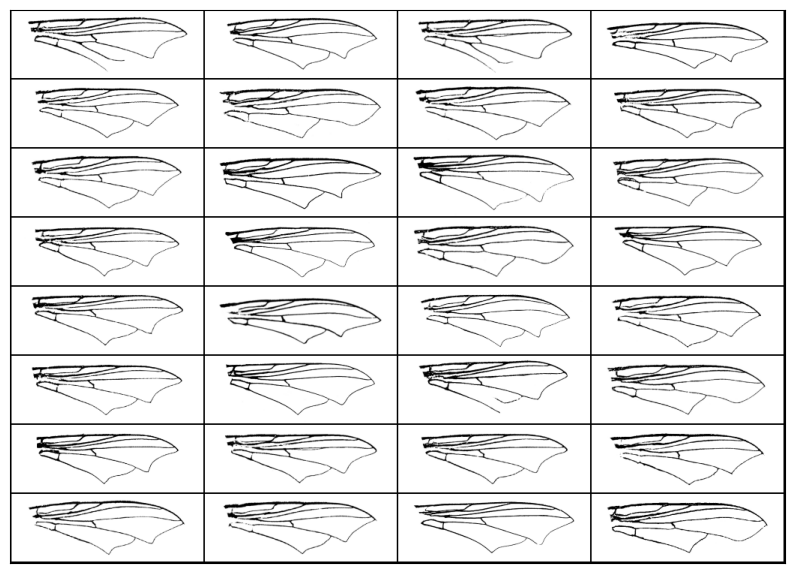

In [ ]:
# Example of a batch of training data

from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
        break

show_batch(train_dl)

## GPU Setup

In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = train_dataset[0]

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training

In [ ]:
weight = torch.tensor([])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32

        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(1, len(train_dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model.

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([32, 1, 90, 256])
images.device cuda:0
preds.shape torch.Size([32, 14])


### Training

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.6422369480133057, 'val_acc': 0.02524038404226303}]

In [ ]:
history += fit(40, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 4.1676, val_loss: 3.3323, val_acc: 0.1340
Epoch [1], train_loss: 2.5429, val_loss: 2.3960, val_acc: 0.1671
Epoch [2], train_loss: 2.0925, val_loss: 1.7345, val_acc: 0.4062
Epoch [3], train_loss: 1.8416, val_loss: 1.4088, val_acc: 0.5619
Epoch [4], train_loss: 1.4831, val_loss: 1.0011, val_acc: 0.7488
Epoch [5], train_loss: 1.1731, val_loss: 0.8805, val_acc: 0.7915
Epoch [6], train_loss: 0.8540, val_loss: 0.8250, val_acc: 0.6863
Epoch [7], train_loss: 0.7756, val_loss: 0.8606, val_acc: 0.7019
Epoch [8], train_loss: 0.6711, val_loss: 0.8119, val_acc: 0.7915
Epoch [9], train_loss: 0.5191, val_loss: 0.6640, val_acc: 0.8269
Epoch [10], train_loss: 0.4339, val_loss: 0.4841, val_acc: 0.8341
Epoch [11], train_loss: 0.3051, val_loss: 0.5982, val_acc: 0.8287
Epoch [12], train_loss: 0.3577, val_loss: 0.6519, val_acc: 0.8077
Epoch [13], train_loss: 0.3441, val_loss: 0.4687, val_acc: 0.8558
Epoch [14], train_loss: 0.2113, val_loss: 0.4249, val_acc: 0.8792
Epoch [15], train_lo

In [ ]:
history += fit(40, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.0542, val_loss: 0.0824, val_acc: 0.9688
Epoch [1], train_loss: 0.0063, val_loss: 0.1514, val_acc: 0.9669
Epoch [2], train_loss: 0.0059, val_loss: 0.1115, val_acc: 0.9688
Epoch [3], train_loss: 0.0058, val_loss: 0.1096, val_acc: 0.9688
Epoch [4], train_loss: 0.0024, val_loss: 0.1321, val_acc: 0.9609
Epoch [5], train_loss: 0.0031, val_loss: 0.1335, val_acc: 0.9609
Epoch [6], train_loss: 0.0014, val_loss: 0.1205, val_acc: 0.9766
Epoch [7], train_loss: 0.0036, val_loss: 0.1979, val_acc: 0.9591
Epoch [8], train_loss: 0.0094, val_loss: 0.1634, val_acc: 0.9435
Epoch [9], train_loss: 0.0059, val_loss: 0.1264, val_acc: 0.9609
Epoch [10], train_loss: 0.0026, val_loss: 0.1102, val_acc: 0.9609
Epoch [11], train_loss: 0.0047, val_loss: 0.1172, val_acc: 0.9766
Epoch [12], train_loss: 0.0019, val_loss: 0.1290, val_acc: 0.9688
Epoch [13], train_loss: 0.0013, val_loss: 0.1411, val_acc: 0.9609
Epoch [14], train_loss: 0.0033, val_loss: 0.1658, val_acc: 0.9531
Epoch [15], train_lo

In [ ]:
history += fit(40, 0.00001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.0015, val_loss: 0.1079, val_acc: 0.9844
Epoch [1], train_loss: 0.0003, val_loss: 0.1056, val_acc: 0.9844
Epoch [2], train_loss: 0.0006, val_loss: 0.1166, val_acc: 0.9844
Epoch [3], train_loss: 0.0005, val_loss: 0.1103, val_acc: 0.9766
Epoch [4], train_loss: 0.0006, val_loss: 0.0975, val_acc: 0.9688
Epoch [5], train_loss: 0.0006, val_loss: 0.0983, val_acc: 0.9766
Epoch [6], train_loss: 0.0033, val_loss: 0.1004, val_acc: 0.9766
Epoch [7], train_loss: 0.0005, val_loss: 0.0958, val_acc: 0.9766
Epoch [8], train_loss: 0.0002, val_loss: 0.0944, val_acc: 0.9766
Epoch [9], train_loss: 0.0007, val_loss: 0.0932, val_acc: 0.9766
Epoch [10], train_loss: 0.0003, val_loss: 0.0967, val_acc: 0.9766
Epoch [11], train_loss: 0.0002, val_loss: 0.0922, val_acc: 0.9766
Epoch [12], train_loss: 0.0005, val_loss: 0.0886, val_acc: 0.9688
Epoch [13], train_loss: 0.0002, val_loss: 0.0924, val_acc: 0.9688
Epoch [14], train_loss: 0.0005, val_loss: 0.1014, val_acc: 0.9766
Epoch [15], train_lo

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

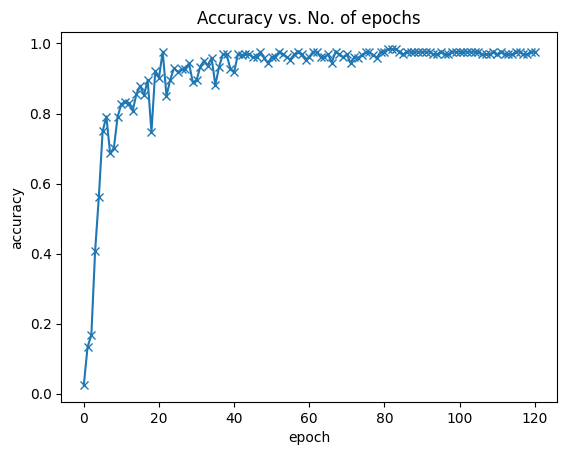

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

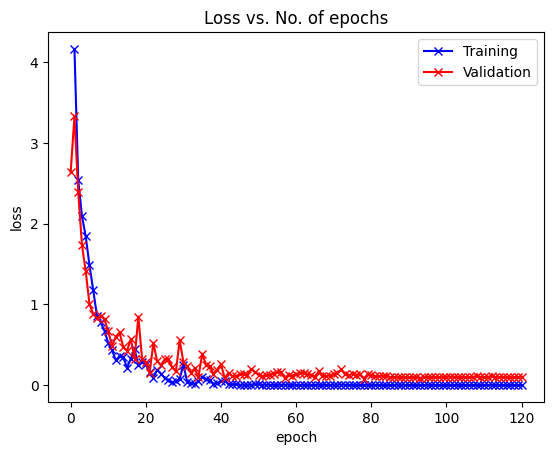

In [ ]:
plot_losses(history)

In [ ]:
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
torch.save(model.state_dict(), './model')

### Testing

In [ ]:
def familyClass(species_name):
  if species_name in ['C.vicina', 'C.albiceps', 'C.albiceps_mutant', 'C.bezziana', 'C.megacephala', 'C.nigripes', 'C.rufifacies', 'L.sericata']:
    return 'Calliphoridae'
  elif species_name in ['B.karnyi', 'S.aquila', 'L.alba', 'S.princeps', 'A.gressitti']:
    return 'Sarcophagidae'
  else:
    return 'Muscidae'

def minorClass(species_name):
  if species_name in ['B.karnyi', 'S.aquila', 'L.alba', 'S.princeps', 'A.gressitti', 'C.nigripes']:
    return 'Yes'
  else:
    return 'No'

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['Target', 'Prediction', 'TargetFamily', 'PredictionFamily', 'minorClass'])

number_of_test_image = len(test_ds)

for i in range(number_of_test_image):
  img, label = test_ds[i]
  pred = predict_image(img, model, test_dataset.classes)

  new_row = pd.DataFrame({'Target': [test_dataset.classes[label]],
                        'Prediction': [pred],
                        'TargetFamily': [familyClass(test_dataset.classes[label])],
                        'PredictionFamily': [familyClass(pred)],
                        'minorClass': [minorClass(test_dataset.classes[label])]})
  df = pd.concat([df, new_row])

df['TargetIndex'] = [os.path.basename(imgpath) for imgpath, label in test_dataset.imgs]
df['Match'] = (df['Target'] == df['Prediction']).astype(int)
df['MatchFamily'] = (df['TargetFamily'] == df['PredictionFamily']).astype(int)

df

,Target,Prediction,TargetFamily,PredictionFamily,minorClass,TargetIndex,Match,MatchFamily
0,A.gressitti,A.gressitti,Sarcophagidae,Sarcophagidae,Yes,A.gressitti.3.png,1,1
0,A.gressitti,A.gressitti,Sarcophagidae,Sarcophagidae,Yes,A.gressitti.8.png,1,1
0,B.karnyi,B.karnyi,Sarcophagidae,Sarcophagidae,Yes,B.karnyi.10.png,1,1
0,B.karnyi,B.karnyi,Sarcophagidae,Sarcophagidae,Yes,B.karnyi.14.png,1,1
0,B.karnyi,B.karnyi,Sarcophagidae,Sarcophagidae,Yes,B.karnyi.18.png,1,1
...,...,...,...,...,...,...,...,...
0,S.nudiseta,S.nudiseta,Muscidae,Muscidae,No,S.nudiseta.89.png,1,1
0,S.nudiseta,S.nudiseta,Muscidae,Muscidae,No,S.nudiseta.90.png,1,1
0,S.nudiseta,S.nudiseta,Muscidae,Muscidae,No,S.nudiseta.92.png,1,1
0,S.princeps,S.princeps,Sarcophagidae,Sarcophagidae,Yes,S.princeps.6.png,1,1


In [ ]:
# Test set accuracy (Species Level)
print("Test set accuracy (Family Level) = " + str(round(df['MatchFamily'].sum() / number_of_test_image * 100, 2)) + "% (" +
      str(df['MatchFamily'].sum()) + "/" + str(number_of_test_image) + ")")
print("Test set accuracy (Species Level) = " + str(round(df['Match'].sum() / number_of_test_image * 100, 2)) + "% (" +
      str(df['Match'].sum()) + "/" + str(number_of_test_image) + ")")
print("Majoriy class accuracy = " + str(round(df[df['minorClass'] == "Yes"]['Match'].sum() / df[df['minorClass'] == "Yes"].shape[0] * 100, 2)) +
      "% (" + str(df[df['minorClass'] == "Yes"]['Match'].sum()) + "/" + str(df[df['minorClass'] == "Yes"].shape[0]) + ")")
print("Minority class accuracy = " + str(round(df[df['minorClass'] == "No"]['Match'].sum() / df[df['minorClass'] == "No"].shape[0] * 100, 2)) +
      "% (" + str(df[df['minorClass'] == "No"]['Match'].sum()) + "/" + str(df[df['minorClass'] == "No"].shape[0]) + ")")


# Species Level Precision, Recall & F1 Score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

def speciesLevelMetric(species_name):
  y_true = []
  y_pred = []
  for item in df['Target']:
    if item == species_name:
      y_true.append(1)
    else:
      y_true.append(0)

  for item in df['Prediction']:
    if item == species_name:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return (y_true, y_pred)

def precisionRecallF1Df(species_name):
  precision = round(precision_score(speciesLevelMetric(species_name)[0], speciesLevelMetric(species_name)[1]), 2)
  recall = round(recall_score(speciesLevelMetric(species_name)[0], speciesLevelMetric(species_name)[1]), 2)
  f1 = round((2 * precision * recall) / (precision + recall), 2)

  return pd.DataFrame(np.array([species_name, precision, recall, f1]).reshape(1,-1), columns = ['Species', 'Precision', 'Recall', 'F1_score'])

speciesLevelMetricDf = pd.DataFrame(columns=['Species', 'Precision', 'Recall', 'F1_score'])

for species_name in df['Target'].unique():
  new_row = pd.DataFrame(precisionRecallF1Df(species_name))
  speciesLevelMetricDf = pd.concat([speciesLevelMetricDf, new_row])

print('Precision, Recall & F1 score for each species')
print(speciesLevelMetricDf)

# List of wrong predictions
wrongPredictionDf = df[df['Target'] != df['Prediction']]
print('List of wrong predictions')
print(wrongPredictionDf[['Target', 'Prediction', 'TargetIndex']])

Test set accuracy (Family Level) = 100.0% (152/152)
Test set accuracy (Species Level) = 99.34% (151/152)
Majoriy class accuracy = 93.75% (15/16)
Minority class accuracy = 100.0% (136/136)
Precision, Recall & F1 score for each species
             Species Precision Recall F1_score
0        A.gressitti       1.0    1.0      1.0
0           B.karnyi       0.8    1.0     0.89
0         C.albiceps       1.0    1.0      1.0
0  C.albiceps_mutant       1.0    1.0      1.0
0         C.bezziana       1.0    1.0      1.0
0      C.megacephala       1.0    1.0      1.0
0         C.nigripes       1.0    1.0      1.0
0       C.rufifacies       1.0    1.0      1.0
0           C.vicina       1.0    1.0      1.0
0             L.alba       1.0    1.0      1.0
0         L.sericata       1.0    1.0      1.0
0           S.aquila       1.0   0.75     0.86
0         S.nudiseta       1.0    1.0      1.0
0         S.princeps       1.0    1.0      1.0
List of wrong predictions
     Target Prediction     TargetIn

### Model explainability using Grad-CAM


In [ ]:
!pip install grad-cam torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 74.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 M

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision.transforms as tt

test_transform = tt.Compose([tt.Grayscale(), tt.ToTensor()])
folder_path = "./fold1/test"

file_name = []
for i in os.listdir(folder_path):
    species_name = i
    for j in os.listdir(os.path.join(folder_path,species_name)):
      file_name.append(os.path.join(folder_path, species_name, j))

In [ ]:
# Get model explainability using gradcam

import torchcam
from torchcam.utils import overlay_mask
from pytorch_grad_cam import GradCAM

for img_path in file_name:
  img_pil = Image.open(img_path)
  input_tensor = test_transform(img_pil).unsqueeze(0).to(device)

  # Grad-CAM setup
  target_layers = [model.res2[-1]]
  cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
  cam_map = cam(input_tensor = input_tensor, targets=None)[0]
  result = overlay_mask(img_pil.convert('RGB'), Image.fromarray(cam_map), alpha=0.6)
  path = os.path.relpath(img_path, "./fold1/test").split("/")
  if not os.path.exists(os.path.join("output", path[0])):
    os.makedirs(os.path.join("output", path[0]))
  result.save(os.path.join("output", path[0], path[1]))